In [142]:
import pymc as pm

In [195]:
import arviz as az
import graphviz

In [4]:
import pandas as pd
import numpy as np

In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

Data extraction from csv files. Partially cleaned in R and partially cleaned here

In [66]:
modality_df = pd.read_csv("modality.csv")
accuracies_df = pd.read_csv("accs.csv")
ssrt_df = pd.read_csv("ssrt_sif.csv")
learned = pd.read_csv("learned.csv")
slopes = pd.read_csv("slopes.csv")

In [72]:
lM1_accuracy = accuracies_df.loc[accuracies_df['roi'] == 'lM1'].sort_values(by=['type', 'sid'])
rHC_accuracy = accuracies_df.loc[accuracies_df['roi'] == 'rHC'].sort_values(by=['type', 'sid'])
rlpfc_accuracy = accuracies_df.loc[accuracies_df['roi'] == 'rlpfc'].sort_values(by=['type', 'sid'])
rlpfc_slope = slopes.loc[slopes['ROI'] == 'rlpfc'].sort_values(by=['sid'])['propslope']
variable_array = np.concatenate((np.ones(24), np.zeros(24)))
action_array = np.concatenate((np.zeros(24), np.ones(24)))

In [53]:
def remove_elements(arr):
    indices_to_remove = [20, 21, 22, 23, 44, 45, 46, 47] # indices are 0-based
    arr = np.array(arr)
    return arr[indices_to_remove], np.delete(arr, indices_to_remove)


In [76]:
remove_indices = [20, 21, 22, 23, 44, 45, 46, 47]
df_filtered = modality_df.loc[modality_df['roi'] == 'rHC'].rename(columns={'PSC': 'activation_hippocampus'})
df_m1 = modality_df.loc[modality_df['roi'] == 'lM1']
activation_m1_cv, activation_m1 = remove_elements(df_m1['PSC'])
activation_hippocampus_cv, activation_hippocampus = remove_elements(df_filtered['activation_hippocampus'])
classifier_acc_m1 = lM1_accuracy['acc']
classifier_acc_hippocampus = rHC_accuracy['acc']
classifier_acc_rlpfc_cv, classifier_acc_rlpfc = remove_elements(rlpfc_accuracy['acc'])
rlpfc_sloped_cv, rlpfc_sloped_cv = remove_elements(pd.concat([rlpfc_slope, rlpfc_slope], ignore_index=True))
reaction_time_cv, reaction_time = remove_elements(pd.concat([ssrt_df, ssrt_df], ignore_index=True)["SSRT"])
sif_cv, sif = remove_elements(pd.concat([ssrt_df, ssrt_df], ignore_index=True)["SIF"])
wm_cv, wm = remove_elements(pd.concat([learned, learned], ignore_index=True)["criterion"])
memory_retrieval_cv, memory_retrieval = remove_elements(variable_array)
action_stopping_cv, action_stopping = remove_elements(action_array)

Original incomplete model without language data. Working memory is compressed into second layer for less divergence

In [169]:
#n = 40
coords1 = {"n": np.arange(len(activation_m1))}
with pm.Model() as model:
    n = pm.MutableData("n", 40)
    ac_m1 = pm.MutableData("ac_m1", activation_m1, dims="n")
    ac_hc = pm.MutableData("ac_hc", activation_hippocampus, dims="n")
    ca_rlpfc = pm.MutableData("ca_rlpfc", classifier_acc_rlpfc, dims="n")
    ssrt = pm.MutableData("ssrt", reaction_time, dims="n")
    sif_time = pm.MutableData("sif_time", sif, dims="n")
    learned_wm = pm.MutableData("learned_wm", wm, dims="n")
    #priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    #rho = pm.Uniform("rho", -1, 1)
    ssrt_sif_hat = pm.Normal("ssrt_sif_hat", g[3] * ssrt + g[4] * sif_time)
    # Varying intercepts ssrt model:
    a = pm.Deterministic("a", g[0] + g[1] * ssrt_sif_hat + g[2] * learned_wm, dims="n")
    za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    # Common slope
    b = pm.Normal("b", mu=0.0, sigma=1.0, shape=9)
    ac_m1_hat = pm.Normal("ac_m1_hat", b[3] + b[4] * a_rt, observed=ac_m1, dims="n")
    ac_hc_hat = pm.Normal("ac_hc_hat", b[5] + b[6] * a_rt, observed=ac_hc, dims="n")
    ca_rlpfc_hat = pm.Normal("ca_rlpfc_hat", b[7] + b[8] * a_rt, observed=ca_rlpfc, dims="n")
    # Expected value:
    theta = a_rt + b[0] * ac_m1_hat + b[1] * ac_hc_hat + b[2] * ca_rlpfc_hat
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    mem_retrieval = pm.Normal("mem_retrieval", theta, sigma=sigma, observed=memory_retrieval, dims="n")

    idata_inc = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, sigma_a, ssrt_sif_hat, za_rt, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 299 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3029 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Original incomplete model executed counterfactually, with the SIF and working memory components removed

In [164]:
with pm.Model() as counterfactual_model:
    n = pm.MutableData("n", 8)
    ac_m1 = pm.MutableData("ac_m1", activation_m1, dims="n")
    ac_hc = pm.MutableData("ac_hc", activation_hippocampus, dims="n")
    ca_rlpfc = pm.MutableData("ca_rlpfc", classifier_acc_rlpfc, dims="n")
    ssrt = pm.MutableData("ssrt", reaction_time, dims="n")
    #priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=2)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    #rho = pm.Uniform("rho", -1, 1)
    # Varying intercepts ssrt model:
    a = pm.Deterministic("a", g[0] + g[1] * ssrt, dims="n")
    za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=1.0, shape=9)
    ac_m1_hat = pm.Normal("ac_m1_hat", b[3] + b[4] * a_rt, observed=ac_m1, dims="n")
    ac_hc_hat = pm.Normal("ac_hc_hat", b[5] + b[6] * a_rt, observed=ac_hc, dims="n")
    ca_rlpfc_hat = pm.Normal("ca_rlpfc_hat", b[7] + b[8] * a_rt, observed=ca_rlpfc, dims="n")
    # Expected value:
    theta = a_rt + b[0] * ac_m1_hat + b[1] * ac_hc_hat + b[2] * ca_rlpfc_hat
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    mem_retrieval = pm.Normal("mem_retrieval", theta, sigma=sigma, observed=memory_retrieval, dims="n")

    idata_inc_counterfactual = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, sigma_a, za_rt, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


Skeleton of complete model, using dummy data

In [190]:
coords = {"n": np.arange(len(activation_m1))}
with pm.Model(coords=coords) as lang_model:
    ac_m1 = pm.MutableData("ac_m1", activation_m1, dims="n")
    ac_hc = pm.MutableData("ac_hc", activation_hippocampus, dims="n")
    ca_rlpfc = pm.MutableData("ca_rlpfc", classifier_acc_rlpfc, dims="n")
    ssrt = pm.MutableData("ssrt", reaction_time, dims="n")
    sif_time = pm.MutableData("sif_time", sif, dims="n")
    learned_wm = pm.MutableData("learned_wm", wm, dims="n")
    # Dummy values
    switch_latency = pm.MutableData("switch_latency", reaction_time, dims="n")
    l1_l3_sim = pm.MutableData("l1_l3_sim", classifier_acc_rlpfc, dims="n")
    l2_l3_sim = pm.MutableData("l2_l3_sim", classifier_acc_rlpfc, dims="n")
    arr = np.random.randint(low=1, high=7, size=len(activation_m1))
    l1_prof = pm.MutableData("l1_prof", arr, dims="n")
    l2_prof = pm.MutableData("l2_prof", arr, dims="n")
    l3_prof = pm.MutableData("l3_prof", arr, dims="n")
    # 1 --> L1, 2 --> L2
    switched_from = pm.MutableData("switched_from", np.random.randint(low=1, high=3, size=len(activation_m1)), dims="n")
    # Time between learning languages in years
    l2_l3_dist = pm.MutableData("l2_l3_dist", classifier_acc_rlpfc, dims="n")
    l1_l2_dist = pm.MutableData("l1_l2_dist", classifier_acc_rlpfc, dims="n")
    #priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=9)
    h = pm.Normal("h", mu=0.0, sigma=100.0, shape=12)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    lang_sim_hat = pm.Normal("lang_sim_hat", h[1] * l1_l3_sim + h[2] * l2_l3_sim + h[11] * switched_from, dims="n")
    c = pm.Deterministic("c", h[0] + h[3] * learned_wm + h[4] * l1_prof + h[5] * l2_prof + h[6] * l3_prof + h[7] * l2_l3_dist 
                         + h[8] * l1_l2_dist + h[9] * switched_from + h[10] * lang_sim_hat, dims="n")
    zc_lang = pm.Normal("zc_lang", mu=0.0, sigma=1.0, dims="n")
    c_lang = pm.Deterministic("c_lang", c + zc_lang * sigma_c, dims="n")
    #rho = pm.Uniform("rho", -1, 1)
    switch_latency_hat = pm.Normal("switch_latency_hat", g[7] + g[8] * c_lang, observed=switch_latency, dims="n")
    ssrt_sif_hat = pm.Normal("ssrt_sif_lat_hat", g[3] * ssrt + g[4] * sif_time + g[5] * switch_latency_hat + g[6] * c_lang)
    # Varying intercepts ssrt model:
    a = pm.Deterministic("a", g[0] + g[1] * ssrt_sif_hat + g[2] * c_lang, dims="n")
    za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    #a_cov = pm.math.stack([ac_hc, a_rt], axis=1)
    #mu_a = pm.Deterministic("mu_a", g[0] + g[1] * ac_hc, dims="n")
    #Sigma_a = pm.math.stack([[sigma_a ** 2, rho * sigma_a ** 2], [rho * sigma_a ** 2, sigma_a ** 2]])
    #a_cov = pm.MvNormal("a_cov", mu=mu_a, cov=Sigma_a, dims="n")
    #za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    #a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=1.0, shape=9)
    ac_m1_hat = pm.Normal("ac_m1_hat", b[3] + b[4] * a_rt, observed=ac_m1, dims="n")
    ac_hc_hat = pm.Normal("ac_hc_hat", b[5] + b[6] * a_rt, observed=ac_hc, dims="n")
    ca_rlpfc_hat = pm.Normal("ca_rlpfc_hat", b[7] + b[8] * a_rt, observed=ca_rlpfc, dims="n")
    # Expected value:
    theta = a_rt + c_lang + b[0] * ac_m1_hat + b[1] * ac_hc_hat + b[2] * ca_rlpfc_hat
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    mem_retrieval = pm.Normal("mem_retrieval", theta, sigma=sigma, observed=memory_retrieval, dims="n")

    #idata_comp = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

In [ ]:
Skeleton of complete model counterfactually 

In [193]:
coords = {"n": np.arange(len(activation_m1))}
with pm.Model(coords=coords) as lang_model_cf:
    ac_m1 = pm.MutableData("ac_m1", activation_m1, dims="n")
    ac_hc = pm.MutableData("ac_hc", activation_hippocampus, dims="n")
    ca_rlpfc = pm.MutableData("ca_rlpfc", classifier_acc_rlpfc, dims="n")
    ssrt = pm.MutableData("ssrt", reaction_time, dims="n")
    # Dummy values
    switch_latency = pm.MutableData("switch_latency", reaction_time, dims="n")
    arr = np.random.randint(low=1, high=7, size=len(activation_m1))
    l1_prof = pm.MutableData("l1_prof", arr, dims="n")
    l2_prof = pm.MutableData("l2_prof", arr, dims="n")
    l3_prof = pm.MutableData("l3_prof", arr, dims="n")
    # 1 --> L1, 2 --> L2
    switched_from = pm.MutableData("switched_from", np.random.randint(low=1, high=3, size=len(activation_m1)), dims="n")
    #priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=9)
    h = pm.Normal("h", mu=0.0, sigma=100.0, shape=5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    c = pm.Deterministic("c", h[0] + h[1] * l1_prof + h[2] * l2_prof + h[3] * l3_prof + h[4] * switched_from, dims="n")
    zc_lang = pm.Normal("zc_lang", mu=0.0, sigma=1.0, dims="n")
    c_lang = pm.Deterministic("c_lang", c + zc_lang * sigma_c, dims="n")
    #rho = pm.Uniform("rho", -1, 1)
    switch_latency_hat = pm.Normal("switch_latency_hat", g[7] + g[8] * c_lang, observed=switch_latency, dims="n")
    ssrt_sif_hat = pm.Normal("ssrt_sif_lat_hat", g[3] * ssrt + g[4] * sif_time + g[5] * switch_latency_hat + g[6] * c_lang)
    # Varying intercepts ssrt model:
    a = pm.Deterministic("a", g[0] + g[1] * ssrt_sif_hat + g[2] * c_lang, dims="n")
    za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    #a_cov = pm.math.stack([ac_hc, a_rt], axis=1)
    #mu_a = pm.Deterministic("mu_a", g[0] + g[1] * ac_hc, dims="n")
    #Sigma_a = pm.math.stack([[sigma_a ** 2, rho * sigma_a ** 2], [rho * sigma_a ** 2, sigma_a ** 2]])
    #a_cov = pm.MvNormal("a_cov", mu=mu_a, cov=Sigma_a, dims="n")
    #za_rt = pm.Normal("za_rt", mu=0.0, sigma=1.0, dims="n")
    #a_rt = pm.Deterministic("a_rt", a + za_rt * sigma_a, dims="n")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=1.0, shape=9)
    ac_m1_hat = pm.Normal("ac_m1_hat", b[3] + b[4] * a_rt, observed=ac_m1, dims="n")
    ac_hc_hat = pm.Normal("ac_hc_hat", b[5] + b[6] * a_rt, observed=ac_hc, dims="n")
    ca_rlpfc_hat = pm.Normal("ca_rlpfc_hat", b[7] + b[8] * a_rt, observed=ca_rlpfc, dims="n")
    # Expected value:
    theta = a_rt + c_lang + b[0] * ac_m1_hat + b[1] * ac_hc_hat + b[2] * ca_rlpfc_hat
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    mem_retrieval = pm.Normal("mem_retrieval", theta, sigma=sigma, observed=memory_retrieval, dims="n")

    #idata_comp_cf = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

In [178]:
with model:
    pm.set_data(
        {
        "n": 8,
        "ac_m1": activation_m1_cv,
         "ac_hc": activation_hippocampus_cv, 
         "ca_rlpfc": classifier_acc_rlpfc_cv,
         "ssrt" : reaction_time_cv, 
          "sif_time": sif_cv,
          "learned_wm": wm_cv}
    )
    real_cv = pm.sample_posterior_predictive(
        idata_inc, var_names=["mem_retrieval"], random_seed=RANDOM_SEED
    )

Sampling: [ac_hc_hat, ac_m1_hat, ca_rlpfc_hat, mem_retrieval, ssrt_sif_hat, za_rt]


In [179]:
with counterfactual_model:
    pm.set_data(
        {
        "n": 8,
        "ac_m1": activation_m1_cv,
         "ac_hc": activation_hippocampus_cv, 
         "ca_rlpfc": classifier_acc_rlpfc_cv,
         "ssrt" : reaction_time_cv}
    )
    cf_cv = pm.sample_posterior_predictive(
        idata_inc_counterfactual, var_names=["mem_retrieval"], random_seed=RANDOM_SEED
    )

Sampling: [ac_hc_hat, ac_m1_hat, ca_rlpfc_hat, mem_retrieval, za_rt]


In [205]:
real_cv.posterior_predictive.mean(dim=("chain", "draw"))

<xarray.Dataset>
Dimensions:        (n: 8)
Coordinates:
  * n              (n) int64 0 1 2 3 4 5 6 7
Data variables:
    mem_retrieval  (n) float64 0.5206 0.4527 0.4899 ... 0.3794 0.478 0.5018

In [206]:
cf_cv.posterior_predictive.mean(dim=("chain", "draw"))

<xarray.Dataset>
Dimensions:        (n: 8)
Coordinates:
  * n              (n) int64 0 1 2 3 4 5 6 7
Data variables:
    mem_retrieval  (n) float64 0.5145 0.4947 0.472 ... 0.4876 0.5805 0.5452

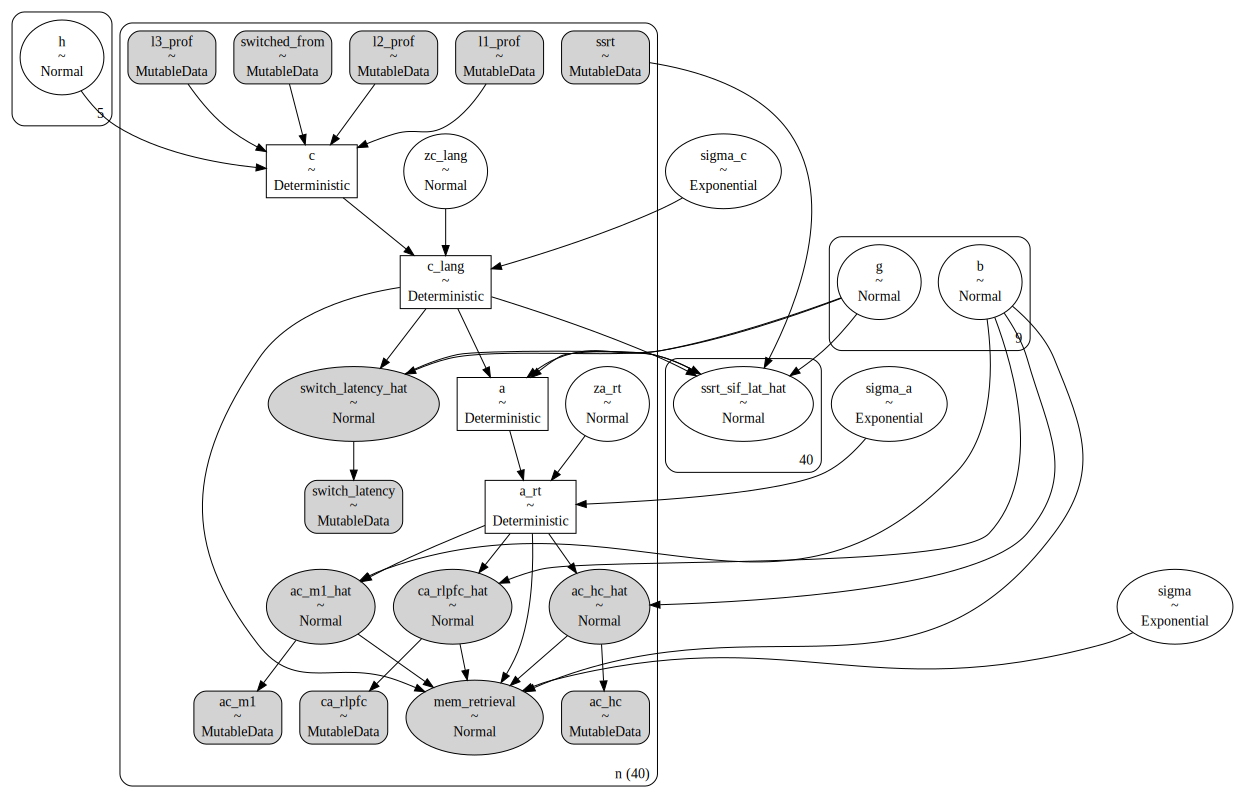

In [194]:
pm.model_to_graphviz(lang_model_cf)

In [209]:
az.summary(idata_inc_counterfactual, var_names=["b","g"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],1.70,0.34,1.09,2.38,0.01,0.00,2696.24,2474.25,1.0
b[1],-0.78,0.40,-1.57,-0.07,0.01,0.01,3222.65,2500.73,1.0
b[2],0.47,0.40,-0.28,1.24,0.01,0.01,1332.30,1507.55,1.0
b[3],-0.11,0.34,-0.78,0.54,0.01,0.01,2079.90,1707.89,1.0
b[4],-0.03,0.77,-1.46,1.41,0.02,0.01,2500.84,2478.98,1.0
b[5],-0.07,0.34,-0.72,0.59,0.01,0.01,2310.44,2188.43,1.0
b[6],-0.01,0.77,-1.47,1.40,0.01,0.01,2820.66,2603.56,1.0
b[7],0.58,0.35,-0.19,1.17,0.01,0.01,2225.38,1898.04,1.0
b[8],0.12,0.77,-1.34,1.64,0.02,0.01,2442.40,2381.81,1.0
g[0],0.40,0.49,-0.54,1.29,0.01,0.01,1448.25,1806.75,1.0


/Users/tspri/Documents/cogs330/venv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (133) in plot_posterior, generating only 40 plots
  warnings.warn(


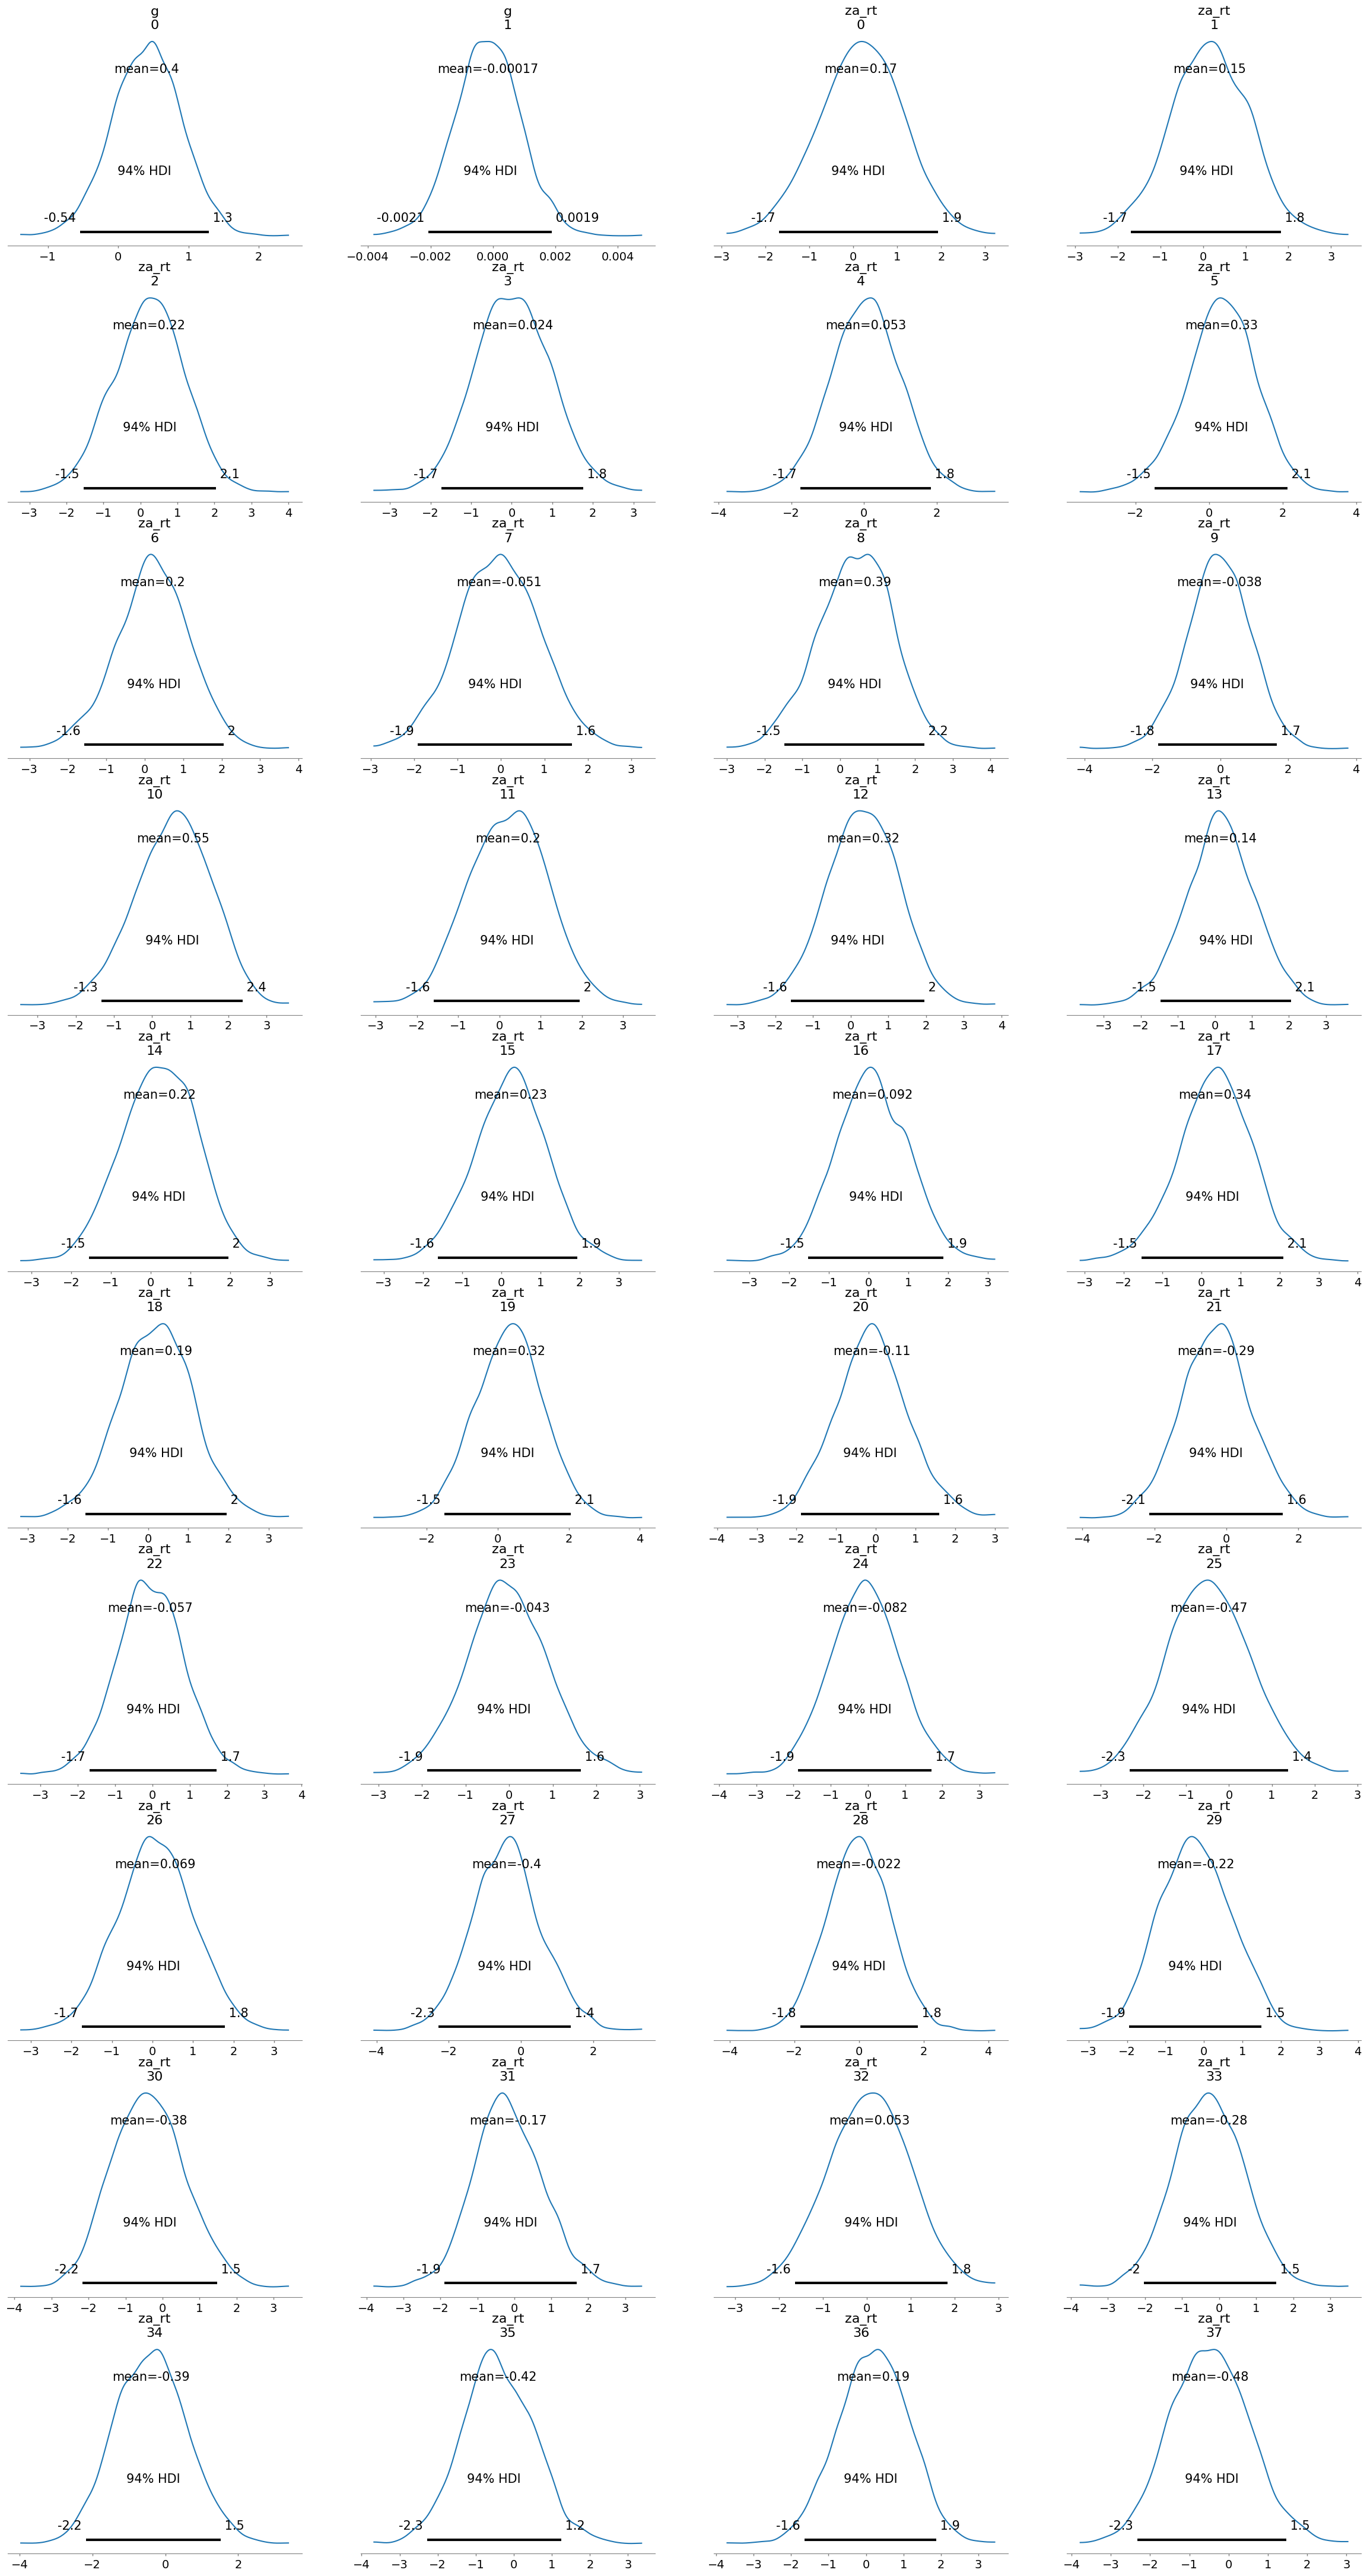

In [208]:
az.plot_posterior(idata_inc_counterfactual);

In [8]:
'''
df_filtered = modality_df.loc[modality_df['roi'] == 'rHC'].rename(columns={'PSC': 'activation_hippocampus'})
df_m1 = modality_df.loc[modality_df['roi'] == 'lM1']
with pm.Model() as model:  
    #inhibitory_control = pm.Bernoulli('inhibitory_control', p=0.5)
    #activation_hippocampus = pm.Normal('activation_hippocampus', mu=0, sigma=1, observed=df_filtered['activation_hippocampus'])
    #activation_m1 = pm.Normal('activation_m1', mu=0, sigma=1, observed=df_m1['PSC'])
    #classifier_acc_m1 =  pm.Normal('acc_m1', mu=0, sigma=1, observed=lM1_accuracy['acc'])
    #classifier_acc_hippocampus = pm.Normal('acc_hippocampus', mu=0, sigma=1, observed=rHC_accuracy['acc'])
    #classifier_acc_rlpfc = pm.Normal('acc_rlpfc', mu=0, sigma=1, observed=rlpfc_accuracy['acc'])
    reaction_time = pm.Normal('reaction_time', mu=0, sigma=1, observed=pd.concat([ssrt_df, ssrt_df], ignore_index=True)["SSRT"])
    memory_retrieval = pm.Normal('memory_retrieval', mu=0, sigma=1, observed=variable_array)
    action_stopping = pm.Normal('action_array', mu=0, sigma=1, observed=action_array)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    beta6 = pm.Normal('beta6', mu=0, sigma=1)
    beta7 = pm.Normal('beta7', mu=0, sigma=1)
    beta8 = pm.Normal('beta8', mu=0, sigma=1)
    beta9 = pm.Normal('beta9', mu=0, sigma=1)
    beta10 = pm.Normal('beta10', mu=0, sigma=1)
    beta11 = pm.Normal('beta11', mu=0, sigma=1)
    beta12 = pm.Normal('beta12', mu=0, sigma=1)
    inhibitory_control_prior = pm.Beta('inhibitory_control_prior', alpha=1, beta=1)
    inhibitory_control = pm.Bernoulli('inhibitory_control', p=inhibitory_control_prior, shape=48)

    p_activation_m1 = pm.math.sigmoid(beta1 * inhibitory_control + beta2 * memory_retrieval + beta3 * reaction_time)
    activation_m1 = pm.Bernoulli('activation_m1', p=p_activation_m1, observed=df_m1['PSC'])
    p_activation_hippocampus = pm.math.sigmoid(beta4 * inhibitory_control + beta5 * action_stopping + beta6 * reaction_time)
    activation_hippocampus = pm.Bernoulli('activation_hippocampus', p=p_activation_hippocampus, observed=df_filtered['activation_hippocampus'])

    p_classifier_acc_m1 = pm.math.sigmoid(beta7 * inhibitory_control + beta8 * reaction_time)
    classifier_acc_m1 = pm.Bernoulli('classifier_acc_m1', p=p_classifier_acc_m1, observed=lM1_accuracy['acc'])

    p_classifier_acc_hippocampus = pm.math.sigmoid(beta8 * inhibitory_control + beta10 * memory_retrieval)
    classifier_acc_hippocampus = pm.Bernoulli('classifier_acc_hippocampus', p=p_classifier_acc_hippocampus, observed=rHC_accuracy['acc'])

    p_classifier_acc_rlpfc = pm.math.sigmoid(beta11 * inhibitory_control + beta12 * memory_retrieval)
    classifier_acc_rlpfc = pm.Bernoulli('classifier_acc_rlpfc', p=p_classifier_acc_rlpfc, observed=pd.concat([rlpfc_accuracy, rlpfc_accuracy], ignore_index=True)['acc'])

    trace = pm.sample(random_seed=RANDOM_SEED) #pm.sample(1000, tune=1000)


'''



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, inhibitory_control_prior]
>BinaryGibbsMetropolis: [inhibitory_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 3171 divergences after tuning. Increase `target_accept` or reparameterize.
